## Introduction

Landslides are a major natural hazard that can cause serious damage to infrastructure and loss of life, especially in mountainous and hilly regions. Traditional landslide mapping methods rely on manual analysis of satellite images, which is time-consuming and difficult to scale. Recent advances in artificial intelligence enable automated landslide detection using deep learning techniques.

In this notebook, a U-Net–based convolutional neural network is used to perform pixel-level landslide segmentation from multi-spectral satellite imagery. The model is trained and evaluated on the Landslide4Sense dataset, and its performance is assessed using Dice coefficient and Intersection over Union (IoU) metrics. A threshold sensitivity analysis is also conducted to determine the optimal probability cutoff for final predictions.


## Import libraries

In [60]:
import pandas as pd
import os
from google.colab import drive
import random, re

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_DIR = "/content/drive/MyDrive/Landslide4Sense"

IMG_DIR  = f"{BASE_DIR}/data/images"
MSK_DIR  = f"{BASE_DIR}/data/masks"
SPLIT_DIR = f"{BASE_DIR}/data/splits"

BATCH_SIZE = 8   # if crash again -> change to 4
IMG_KEY = "img"
MSK_KEY = "mask"


## Splitting to train, validation and test

In [4]:
OUT_DIR = f"{BASE_DIR}/data/splits"
os.makedirs(OUT_DIR, exist_ok=True)

def extract_id(filename, prefix):
    # matches like image_123.h5 or mask_123.h5
    m = re.match(rf"{prefix}_(\d+)\.h5$", filename)
    return int(m.group(1)) if m else None

img_ids = set()
for f in os.listdir(IMG_DIR):
    i = extract_id(f, "image")
    if i is not None:
        img_ids.add(i)

msk_ids = set()
for f in os.listdir(MSK_DIR):
    i = extract_id(f, "mask")
    if i is not None:
        msk_ids.add(i)

paired_ids = sorted(list(img_ids & msk_ids))

print("Images IDs:", len(img_ids))
print("Masks  IDs:", len(msk_ids))
print("Paired IDs:", len(paired_ids))
print("First 10 paired:", paired_ids[:10])
print("Last 10 paired:", paired_ids[-10:])

random.seed(42)
random.shuffle(paired_ids)

n = len(paired_ids)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)

train_ids = paired_ids[:n_train]
val_ids   = paired_ids[n_train:n_train+n_val]
test_ids  = paired_ids[n_train+n_val:]

def write_ids(path, ids):
    with open(path, "w", encoding="utf-8") as f:
        for i in ids:
            f.write(str(i) + "\n")

write_ids(os.path.join(OUT_DIR, "train.txt"), train_ids)
write_ids(os.path.join(OUT_DIR, "val.txt"), val_ids)
write_ids(os.path.join(OUT_DIR, "test.txt"), test_ids)

print("Split done:",
      "Train:", len(train_ids),
      "Val:", len(val_ids),
      "Test:", len(test_ids))

Images IDs: 3799
Masks  IDs: 3799
Paired IDs: 3799
First 10 paired: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Last 10 paired: [3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799]
Split done: Train: 2659 Val: 569 Test: 571


In [5]:
img_path = f"{IMG_DIR}/image_1.h5"
msk_path = f"{MSK_DIR}/mask_1.h5"

with h5py.File(img_path, "r") as f:
    print("IMAGE keys:", list(f.keys()))
    for k in f.keys():
        arr = f[k][:]
        print(k, arr.shape, arr.dtype, arr.min(), arr.max())

with h5py.File(msk_path, "r") as f:
    print("MASK keys:", list(f.keys()))
    for k in f.keys():
        arr = f[k][:]
        print(k, arr.shape, arr.dtype, np.unique(arr)[:10])


IMAGE keys: ['img']
img (128, 128, 14) float64 0.0 6.397335147428777
MASK keys: ['mask']
mask (128, 128) uint8 [0 1]


In [6]:
#Find which file is corrupted (fast scanner)
def extract_id(filename, prefix):
    m = re.match(rf"{prefix}_(\d+)\.h5$", filename)
    return int(m.group(1)) if m else None

img_ids = sorted([extract_id(f,"image") for f in os.listdir(IMG_DIR) if extract_id(f,"image") is not None])
msk_ids = sorted([extract_id(f,"mask")  for f in os.listdir(MSK_DIR) if extract_id(f,"mask")  is not None])
paired_ids = sorted(list(set(img_ids) & set(msk_ids)))

bad = []
for idx in paired_ids:
    try:
        with h5py.File(f"{IMG_DIR}/image_{idx}.h5", "r") as f:
            _ = f["img"][:]
        with h5py.File(f"{MSK_DIR}/mask_{idx}.h5", "r") as f:
            _ = f["mask"][:]
    except Exception as e:
        bad.append(idx)

print("Total paired:", len(paired_ids))
print("Bad files:", len(bad))
print("Bad IDs (first 20):", bad[:20])

Total paired: 3799
Bad files: 1
Bad IDs (first 20): [3423]


In [7]:
#Create GOOD IDs list + new splits
bad_ids = set(bad)
good_ids = [i for i in paired_ids if i not in bad_ids]

random.seed(42)
random.shuffle(good_ids)

n = len(good_ids)
n_train = int(0.70*n)
n_val   = int(0.15*n)

train_ids = good_ids[:n_train]
val_ids   = good_ids[n_train:n_train+n_val]
test_ids  = good_ids[n_train+n_val:]

os.makedirs(SPLIT_DIR, exist_ok=True)

def write_ids(path, ids):
    with open(path, "w") as f:
        for i in ids:
            f.write(str(i) + "\n")

write_ids(f"{SPLIT_DIR}/train.txt", train_ids)
write_ids(f"{SPLIT_DIR}/val.txt", val_ids)
write_ids(f"{SPLIT_DIR}/test.txt", test_ids)

print("Good total:", len(good_ids))
print("Split:", len(train_ids), len(val_ids), len(test_ids))


Good total: 3798
Split: 2658 569 571


## Pipeline for Landslide4Sense

In [8]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
IMG_KEY = "img"
MSK_KEY = "mask"

def read_ids(txt_path):
    with open(txt_path, "r") as f:
        return [int(x.strip()) for x in f if x.strip()]

def _load_h5_pair(idx):
    idx = int(idx)
    img_path = f"{IMG_DIR}/image_{idx}.h5"
    msk_path = f"{MSK_DIR}/mask_{idx}.h5"

    with h5py.File(img_path, "r") as f:
        img = f[IMG_KEY][:].astype(np.float32)

    with h5py.File(msk_path, "r") as f:
        msk = f[MSK_KEY][:].astype(np.float32)

    if msk.ndim == 2:
        msk = msk[..., None]

    # per-sample min-max normalize to 0..1
    mn, mx = img.min(), img.max()
    img = (img - mn) / (mx - mn) if mx > mn else np.zeros_like(img, dtype=np.float32)

    msk = (msk > 0.5).astype(np.float32)
    return img, msk

def load_h5_pair_tf(idx):
    img, msk = tf.numpy_function(_load_h5_pair, [idx], [tf.float32, tf.float32])
    img.set_shape([128, 128, 14])
    msk.set_shape([128, 128, 1])
    return img, msk

def make_dataset(ids, training=False):
    ds = tf.data.Dataset.from_tensor_slices(ids)
    ds = ds.map(load_h5_pair_tf, num_parallel_calls=1)  # important: stable
    if training:
        ds = ds.shuffle(1000, seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ids = read_ids(f"{SPLIT_DIR}/train.txt")
val_ids   = read_ids(f"{SPLIT_DIR}/val.txt")
test_ids  = read_ids(f"{SPLIT_DIR}/test.txt")

train_ds = make_dataset(train_ids, training=True)
val_ds   = make_dataset(val_ids, training=False)
test_ds  = make_dataset(test_ids, training=False)

print("Train/Val/Test:", len(train_ids), len(val_ids), len(test_ids))


Train/Val/Test: 2658 569 571


## Augmentation (training only)

In [9]:
def augment(img, msk):
    flip_lr = tf.random.uniform([]) > 0.5
    flip_ud = tf.random.uniform([]) > 0.5

    img = tf.cond(flip_lr, lambda: tf.image.flip_left_right(img), lambda: img)
    msk = tf.cond(flip_lr, lambda: tf.image.flip_left_right(msk), lambda: msk)

    img = tf.cond(flip_ud, lambda: tf.image.flip_up_down(img), lambda: img)
    msk = tf.cond(flip_ud, lambda: tf.image.flip_up_down(msk), lambda: msk)
    return img, msk

train_ds_aug = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

## Create U-Net model (supports 14 channels)

In [10]:
INPUT_SHAPE = (128, 128, 14)

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet(input_shape=INPUT_SHAPE):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64);     p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128);    p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256);    p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, 512)

    u4 = layers.UpSampling2D()(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, 256)

    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 128)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 64)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)
    return Model(inputs, outputs, name="U_Net_14ch")

model = build_unet()
model.summary()


Model: "U_Net_14ch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,064 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 7,861,601 (29.99 MB)

 Trainable params: 7,855,713 (29.97 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Dice + IoU + Loss

In [11]:
bce = tf.keras.losses.BinaryCrossentropy()

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    denom = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (denom + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))


## Compile + callbacks

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_score]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{BASE_DIR}/unet_best.keras",
        monitor="val_iou_score",
        mode="max",
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_iou_score",
        mode="max",
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_iou_score",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]


In [13]:
#Cache + prefetch properly
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

train_ds_aug = train_ds_aug.cache().prefetch(tf.data.AUTOTUNE)


## Train (start with 15 epochs)

In [14]:
import gc
tf.keras.backend.clear_session()
gc.collect()

0

In [15]:
history = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 450ms/step - dice_coef: 0.1536 - iou_score: 0.0855 - loss: 1.1729 - val_dice_coef: 0.0471 - val_iou_score: 0.0242 - val_loss: 1.0774 - learning_rate: 0.0010
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - dice_coef: 0.4542 - iou_score: 0.3003 - loss: 0.6176 - val_dice_coef: 0.1388 - val_iou_score: 0.0764 - val_loss: 1.1222 - learning_rate: 0.0010
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - dice_coef: 0.6083 - iou_score: 0.4433 - loss: 0.4495 - val_dice_coef: 0.6167 - val_iou_score: 0.4519 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - dice_coef: 0.6460 - iou_score: 0.4828 - loss: 0.4113 - val_dice_coef: 0.6354 - val_iou_score: 0.4716 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - dice_coef: 0.6615 - iou_score: 0.5001 - loss: 0.3950 - val_dice_coef: 0.5450 - val_iou_score: 0.3793 - val_loss: 0.5330 - learning_rate: 0

## Save + evaluate on the TEST set

In [16]:
# Load best model if you saved checkpoints; otherwise evaluate current model
test_results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, test_results)))


36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 474ms/step - dice_coef: 0.6977 - iou_score: 0.5420 - loss: 0.3399
Test results: {'loss': 0.3361515998840332, 'compile_metrics': 0.7058428525924683}


In [17]:
model.evaluate(test_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - dice_coef: 0.6977 - iou_score: 0.5420 - loss: 0.3399


[0.3361515998840332, 0.7058428525924683, 0.5506024360656738]

## Plot training curves (Dice/IoU/Loss)

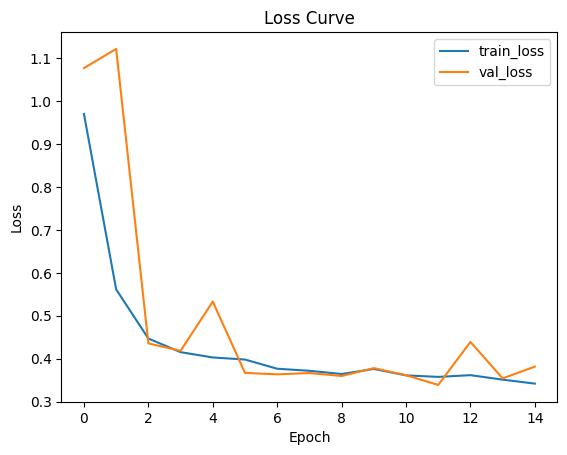

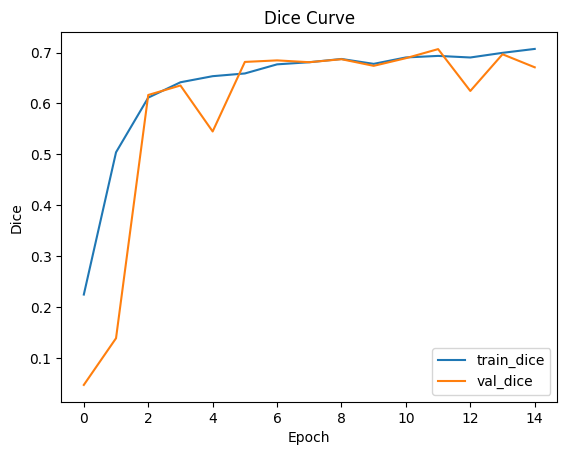

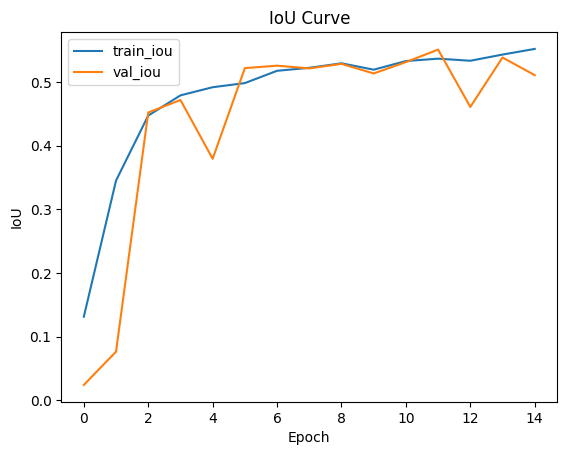

In [18]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()

plt.figure()
plt.plot(history.history["dice_coef"], label="train_dice")
plt.plot(history.history["val_dice_coef"], label="val_dice")
plt.legend(); plt.title("Dice Curve"); plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.show()

plt.figure()
plt.plot(history.history["iou_score"], label="train_iou")
plt.plot(history.history["val_iou_score"], label="val_iou")
plt.legend(); plt.title("IoU Curve"); plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.show()


In [20]:
model.save("landslide_unet_landslide4sense.h5")
model.save("landslide_unet_landslide4sense.keras")


## Finding optimal threshold

In [21]:

def compute_metrics_at_threshold(model, ds, t):
    dices, ious = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        p = (p > t).astype(np.float32)
        y_np = y.numpy().astype(np.float32)

        inter = np.sum(y_np * p)
        dice = (2*inter + 1e-6) / (np.sum(y_np) + np.sum(p) + 1e-6)

        union = np.sum(y_np) + np.sum(p) - inter
        iou = (inter + 1e-6) / (union + 1e-6)

        dices.append(dice)
        ious.append(iou)

    return float(np.mean(dices)), float(np.mean(ious))



In [22]:
thresholds = np.arange(0.10, 0.91, 0.05)

best = {"t": None, "dice": -1, "iou": -1}
for t in thresholds:
    d, i = compute_metrics_at_threshold(model, val_ds, t)
    print(f"t={t:.2f} | val_dice={d:.4f} | val_iou={i:.4f}")
    if i > best["iou"]:
        best = {"t": float(t), "dice": d, "iou": i}

print("\nBEST THRESHOLD (VAL):", best)
best_t = best["t"]


t=0.10 | val_dice=0.7123 | val_iou=0.5571
t=0.15 | val_dice=0.7159 | val_iou=0.5615
t=0.20 | val_dice=0.7177 | val_iou=0.5637
t=0.25 | val_dice=0.7190 | val_iou=0.5653
t=0.30 | val_dice=0.7199 | val_iou=0.5664
t=0.35 | val_dice=0.7203 | val_iou=0.5670
t=0.40 | val_dice=0.7206 | val_iou=0.5674
t=0.45 | val_dice=0.7205 | val_iou=0.5674
t=0.50 | val_dice=0.7204 | val_iou=0.5673
t=0.55 | val_dice=0.7203 | val_iou=0.5671
t=0.60 | val_dice=0.7195 | val_iou=0.5663
t=0.65 | val_dice=0.7187 | val_iou=0.5654
t=0.70 | val_dice=0.7176 | val_iou=0.5639
t=0.75 | val_dice=0.7158 | val_iou=0.5618
t=0.80 | val_dice=0.7136 | val_iou=0.5593
t=0.85 | val_dice=0.7101 | val_iou=0.5551
t=0.90 | val_dice=0.7028 | val_iou=0.5464

BEST THRESHOLD (VAL): {'t': 0.40000000000000013, 'dice': 0.7206041812896729, 'iou': 0.5673975944519043}


In [23]:
test_dice, test_iou = compute_metrics_at_threshold(model, test_ds, best_t)
print("Best threshold:", best_t)
print("Thresholded TEST Dice:", test_dice)
print("Thresholded TEST IoU :", test_iou)


Best threshold: 0.40000000000000013
Thresholded TEST Dice: 0.7193507552146912
Thresholded TEST IoU : 0.5671413540840149


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


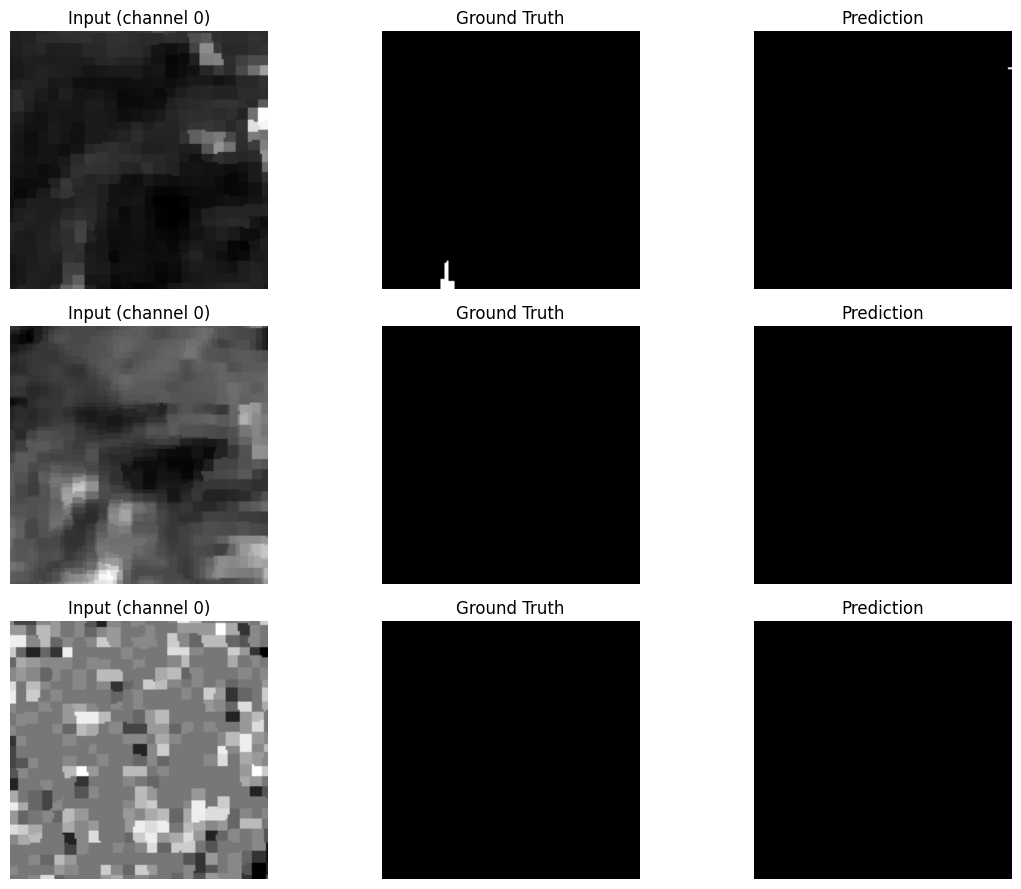

In [19]:
# take one batch from test
for x, y in test_ds.take(1):
    preds = model.predict(x)
    x_np, y_np, p_np = x.numpy(), y.numpy(), preds

# threshold predictions
p_bin = (p_np > 0.5).astype(np.float32)

plt.figure(figsize=(12,9))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(x_np[i,:,:,0], cmap="gray")
    plt.title("Input (channel 0)"); plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(y_np[i].squeeze(), cmap="gray")
    plt.title("Ground Truth"); plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(p_bin[i].squeeze(), cmap="gray")
    plt.title("Prediction"); plt.axis("off")

plt.tight_layout()
plt.show()


In [49]:
import json

best_t = 0.4  # your best threshold
with open("inference_config.json", "w") as f:
    json.dump({"best_threshold": best_t}, f, indent=2)

print("Saved inference_config.json with threshold =", best_t)


Saved inference_config.json with threshold = 0.4


In [25]:
model.save("unet_baseline_best.keras")
print("Saved model: unet_baseline_best.keras")


Saved model: unet_baseline_best.keras


## Results

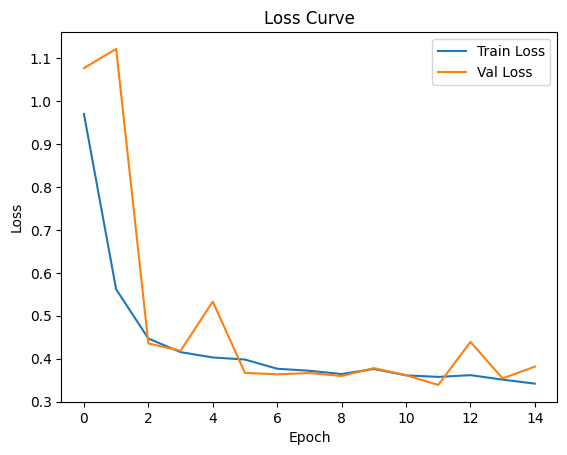

In [41]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig("results/loss_curve.png", dpi=300, bbox_inches="tight")

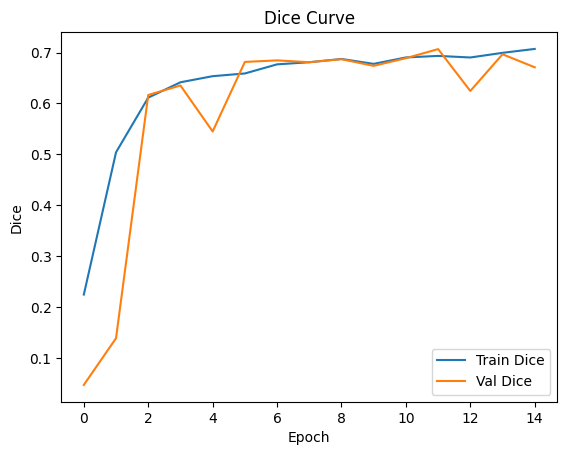

In [43]:
plt.figure()
plt.plot(history.history["dice_coef"], label="Train Dice")
plt.plot(history.history["val_dice_coef"], label="Val Dice")
plt.legend()
plt.title("Dice Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice")

plt.savefig("results/dice_curve.png", dpi=300, bbox_inches="tight")

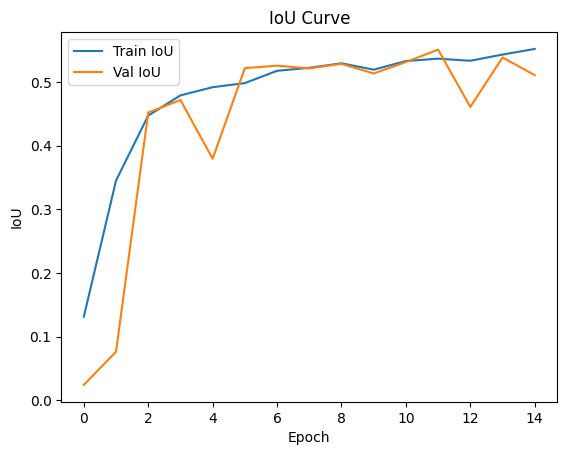

In [44]:
plt.figure()
plt.plot(history.history["iou_score"], label="Train IoU")
plt.plot(history.history["val_iou_score"], label="Val IoU")
plt.legend()
plt.title("IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")

plt.savefig("results/iou_curve.png", dpi=300, bbox_inches="tight")

In [50]:
import json

config = {
    "model": "U-Net",
    "dataset": "Landslide4Sense",
    "input_shape": [128, 128, 14],
    "best_threshold": 0.4,
    "task": "binary semantic segmentation"
}

with open("configs/inference_config.json", "w") as f:
    json.dump(config, f, indent=4)

print("Saved: configs/inference_config.json")


Saved: configs/inference_config.json


In [53]:
from google.colab import files
files.download("results/test_results.png")
files.download("configs/inference_config.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

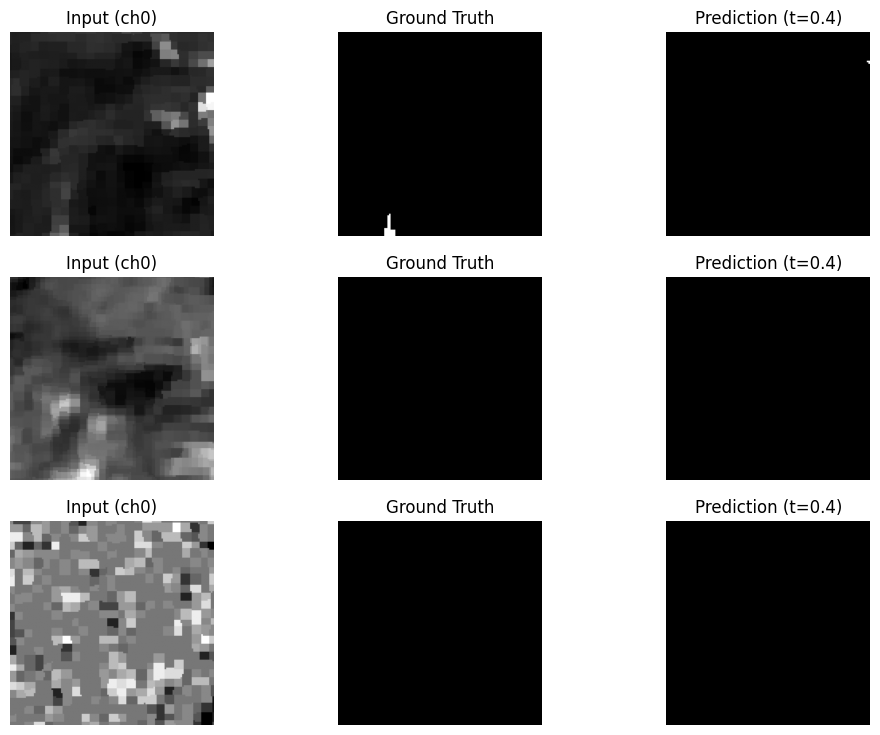

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("results", exist_ok=True)

t = 0.4

for x, y in test_ds.take(1):
    p = model.predict(x, verbose=0)
    p_bin = (p > t).astype(np.float32)
    x_np, y_np = x.numpy(), y.numpy()

plt.figure(figsize=(12,9))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(x_np[i,:,:,0], cmap="gray")
    plt.title("Input (ch0)")
    plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(y_np[i].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(p_bin[i].squeeze(), cmap="gray")
    plt.title(f"Prediction (t={t})")
    plt.axis("off")


In [47]:
thresholds = np.arange(0.10, 0.95, 0.05)

records = []

for t in thresholds:
    dice_list, iou_list, loss_list = [], [], []

    for x, y in val_ds:
        p = model.predict(x, verbose=0)
        p_bin = (p > t).astype(np.float32)

        y_np = y.numpy()

        # ---- Dice & IoU ----
        inter = np.sum(y_np * p_bin)
        dice = (2 * inter) / (np.sum(y_np) + np.sum(p_bin) + 1e-6)
        iou = inter / (np.sum(y_np) + np.sum(p_bin) - inter + 1e-6)

        # ---- Loss (BCE + Dice) ----
        y_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)
        p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
        loss_val = bce_dice_loss(y_tf, p_tf).numpy()

        dice_list.append(dice)
        iou_list.append(iou)
        loss_list.append(loss_val)

    records.append({
        "Threshold": round(float(t), 2),
        "Loss": float(np.mean(loss_list)),
        "Dice": float(np.mean(dice_list)),
        "IoU": float(np.mean(iou_list))
    })

threshold_df = pd.DataFrame(records)
threshold_df


,Threshold,Loss,Dice,IoU
0,0.10,0.338266,0.712317,0.557131
1,0.15,0.338266,0.715930,0.561539
2,0.20,0.338266,0.717661,0.563699
3,0.25,0.338266,0.718981,0.565323
4,0.30,0.338266,0.719886,0.566440
5,0.35,0.338266,0.720345,0.567040
6,0.40,0.338266,0.720604,0.567398
7,0.45,0.338266,0.720522,0.567351
8,0.50,0.338266,0.720434,0.567274
9,0.55,0.338266,0.720278,0.567145


In [48]:
best_row = threshold_df.sort_values("Dice", ascending=False).iloc[0]
best_row


,6
Threshold,0.400000
Loss,0.338266
Dice,0.720604
IoU,0.567398


## Conclusion

This notebook demonstrated an AI-based approach for automated landslide detection using satellite imagery. A U-Net segmentation model achieved strong performance on the Landslide4Sense dataset, with a test Dice score of approximately 0.72 and an IoU score of approximately 0.57. The optimal probability threshold was identified as 0.40 through validation-based analysis.

The results confirm that deep learning–based semantic segmentation is an effective method for landslide detection from remote sensing data. This work provides a solid baseline for further improvements and can support future research in disaster risk monitoring and environmental analysis.
